In [12]:
import os
import re
import PIL
import sys
import json
import time
import timm
import math
import copy
import torch
import pickle
import logging
import fnmatch
import argparse
import itertools
import torchvision
import numpy as np
%matplotlib inline
import pandas as pd
import seaborn as sns
import albumentations
import torch.nn as nn
from PIL import Image
from pathlib import Path
from copy import deepcopy
from sklearn import metrics
import torch.optim as optim
from datetime import datetime
from torchvision import models
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.utils.data as data
from torch.autograd import Variable
from tqdm import tqdm, tqdm_notebook
from torch.optim import lr_scheduler
#from pytorch_metric_learning import loss
import torch.utils.model_zoo as model_zoo
from timm.models.layers.activations import *
from timm.utils import accuracy, AverageMeter
%config InlineBackend.figure_format = 'retina'
from collections import OrderedDict, defaultdict
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, models, datasets
from torch.utils.data.sampler import SubsetRandomSampler
from randaugment import RandAugment, ImageNetPolicy, Cutout
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score, roc_curve, auc, roc_auc_score
#from timm.data import Dataset, DatasetTar, RealLabelsImagenet, create_loader, Mixup, FastCollateMixup, AugMixDataset

In [2]:
torch.backends.cudnn.benchmark = True
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

In [3]:
data_dir = '/home/linh/Downloads/TB/'


# Define your transforms for the training and testing sets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        RandAugment(),
        ImageNetPolicy(),
        Cutout(size=16),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])
}
"""

image_size=224

data_transforms = {
    'train': albumentations.Compose([
                                    albumentations.Transpose(p=0.5),
                                    albumentations.VerticalFlip(p=0.5),
                                    albumentations.HorizontalFlip(p=0.5),
                                    albumentations.RandomBrightness(limit=0.2, p=0.75),
                                    albumentations.RandomContrast(limit=0.2, p=0.75),
                                    albumentations.OneOf([
                                    albumentations.MotionBlur(blur_limit=5),
                                    albumentations.MedianBlur(blur_limit=5),
                                    albumentations.GaussianBlur(blur_limit=5),
                                    albumentations.GaussNoise(var_limit=(5.0, 30.0)),
                                                            ], p=0.7),

                                    albumentations.OneOf([
                                    albumentations.OpticalDistortion(distort_limit=1.0),
                                    albumentations.GridDistortion(num_steps=5, distort_limit=1.),
                                    albumentations.ElasticTransform(alpha=3),
                                                         ], p=0.7),

                                    albumentations.CLAHE(clip_limit=4.0, p=0.7),
                                    albumentations.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
                                    albumentations.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
                                    albumentations.Resize(image_size, image_size),
                                    albumentations.Cutout(max_h_size=int(image_size * 0.375), max_w_size=int(image_size * 0.375), num_holes=1, p=0.7),
                                    albumentations.Normalize(),
                                    RandAugment(),
                                    ImageNetPolicy(),
                                    Cutout(size=16)
                                    ]),

    'val': albumentations.Compose([albumentations.Resize(image_size, image_size),
                                   albumentations.Normalize(),
                                   albumentations.CenterCrop(256)
                                  ])
                    }
"""
# Load the datasets with ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
batch_size = 46
data_loader = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=8, pin_memory = True)
              for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes
print(class_names)
print(dataset_sizes)
print(device)

### we get the class_to_index in the data_Set but what we really need is the cat_to_names  so we will create
_ = image_datasets['train'].class_to_idx
cat_to_name = {_[i]: i for i in list(_.keys())}
print(cat_to_name)
    
# Run this to test the data loader
images, labels = next(iter(data_loader['val']))
images.size()

['Normal', 'TB']
{'train': 1319, 'val': 165}
cuda:0
{0: 'Normal', 1: 'TB'}


torch.Size([46, 3, 224, 224])

/home/linh/anaconda3/envs/fa/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255]

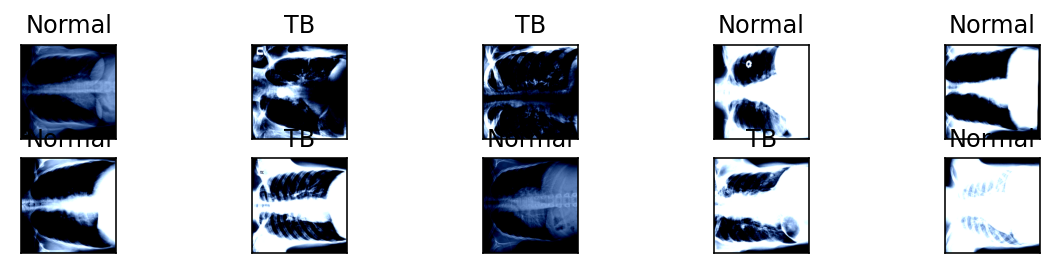

In [4]:
def showimage(data_loader, number_images, cat_to_name):
    dataiter = iter(data_loader)
    images, labels = dataiter.next()
    images = images.numpy() # convert images to numpy for display
    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(number_images, 4))
    for idx in np.arange(number_images):
        ax = fig.add_subplot(4, number_images/2, idx+1, xticks=[], yticks=[])
        img = np.transpose(images[idx])
        plt.imshow(img)
        ax.set_title(cat_to_name[labels.tolist()[idx]])
        
#### to show some  images
showimage(data_loader['test'], 10, cat_to_name)

In [5]:
#model = models.resnet50(pretrained=True)
#model = timm.create_model('resnet50', pretrained=True)
model = timm.create_model('efficientnet_b3', pretrained=True, drop_rate=0.3)
#model.fc #show fully connected layer for ResNet family
model.classifier #show the classifier layer (fully connected layer) for EfficientNets

Linear(in_features=1536, out_features=1000, bias=True)

In [6]:
# Create classifier
for param in model.parameters():
    param.requires_grad = True
# define `classifier` for ResNet
# Otherwise, define `fc` for EfficientNet family 
#because the definition of the full connection/classifier of 2 CNN families is differnt
fc = nn.Sequential(OrderedDict([('fc1', nn.Linear(2048, 1000, bias=True)),
							     ('BN1', nn.BatchNorm2d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('dropout1', nn.Dropout(0.7)),
                                 ('fc2', nn.Linear(1000, 512)),
								 ('BN2', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('swish1', Swish()),
								 ('dropout2', nn.Dropout(0.5)),
								 ('fc3', nn.Linear(512, 128)),
								 ('BN3', nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
							     ('swish2', Swish()),
								 ('fc4', nn.Linear(128, 2)),
								 ('output', nn.Softmax(dim=1))
							 ]))
# connect base model (EfficientNet_B0) with modified classifier layer
model.fc = fc
criterion = LabelSmoothingCrossEntropy()
#criterion = nn.CrossEntropyLoss()
#optimizer = Nadam(model.parameters(), lr=0.001)
#optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
optimizer = optim.SGD(model.parameters(), 
                      lr=0.01,momentum=0.9,
                      nesterov=True,
                      weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
#show our model architechture and send to GPU
model.to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count = count_parameters(model)
print("The number of parameters of the model is:", count)

The number of parameters of the model is: 14863946


In [7]:
model.to(device)
def train_model(model, criterion, optimizer, scheduler, num_epochs=200, checkpoint = None):
    since = time.time()

    if checkpoint is None:
        best_model_wts = copy.deepcopy(model.state_dict())
        best_loss = math.inf
        best_acc = 0.
    else:
        print(f'Val loss: {checkpoint["best_val_loss"]}, Val accuracy: {checkpoint["best_val_accuracy"]}')
        model.load_state_dict(checkpoint['model_state_dict'])
        best_model_wts = copy.deepcopy(model.state_dict())
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        best_loss = checkpoint['best_val_loss']
        best_acc = checkpoint['best_val_accuracy']
   
    # Tensorboard summary
    writer = SummaryWriter()
    start_time_per_epoch = time.time()
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs)) #(epoch, num_epochs -1)
        print('-' * 20)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i, (inputs, labels) in enumerate(data_loader[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                if i % 1000 == 999:
                    print('[%d, %d] loss: %.8f' % 
                          (epoch + 1, i, running_loss / (i * inputs.size(0))))

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':                
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':                
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.8f} Acc: {:.8f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # Record training loss and accuracy for each phase
            if phase == 'train':
                writer.add_scalar('Train/Loss', epoch_loss, epoch)
                writer.add_scalar('Train/Accuracy', epoch_acc, epoch)
                writer.flush()
            else:
                writer.add_scalar('Valid/Loss', epoch_loss, epoch)
                writer.add_scalar('Valid/Accuracy', epoch_acc, epoch)
                writer.flush()
            # deep copy the model
            
            if phase == 'val' and epoch_acc > best_acc:
                print(f'New best model found!')
                print(f'New record ACC: {epoch_acc}, previous record acc: {best_acc}')
                best_loss = epoch_loss
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save({'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'best_val_loss': best_loss,
                            'best_val_accuracy': best_acc,
                            'scheduler_state_dict' : scheduler.state_dict(),
                            }, 
                            CHECK_POINT_PATH
                            )
                print(f'New record acc is SAVED: {epoch_acc}')
                
        end_time_per_epoch = (time.time() - start_time_per_epoch)
        print('Time for training the last epoch: {:.0f}m {:.0f}s'.format(
        end_time_per_epoch // 60, end_time_per_epoch % 60))
        
    time_elapsed = time.time() - since
    print('Total training time complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.8f} Best val loss: {:.8f}'.format(best_acc, best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_loss, best_acc

In [8]:
%time

CHECK_POINT_PATH = '/home/linh/Downloads/TB/weights/EfficientNet_B3.pth'

try:
    checkpoint = torch.load(CHECK_POINT_PATH)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")
if checkpoint == None:
    CHECK_POINT_PATH = CHECK_POINT_PATH
model, best_val_loss, best_val_acc = train_model(model,
                                                 criterion,
                                                 optimizer,
                                                 scheduler,
                                                 num_epochs = 100,
                                                 checkpoint = None #torch.load(CHECK_POINT_PATH)
                                                 ) 
                                                
torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_accuracy': best_val_acc,
            'scheduler_state_dict': scheduler.state_dict(),
            }, CHECK_POINT_PATH)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.48 µs
checkpoint not found
Epoch 1/100
--------------------
train Loss: 2.90092382 Acc: 0.58453374
val Loss: 1.62878551 Acc: 0.80606061
New best model found!
New record ACC: 0.806060606060606, previous record acc: 0.0
New record acc is SAVED: 0.806060606060606
Time for training the last epoch: 0m 29s
Epoch 2/100
--------------------
train Loss: 1.52771114 Acc: 0.79454132
val Loss: 1.36308350 Acc: 0.88484848
New best model found!
New record ACC: 0.8848484848484849, previous record acc: 0.806060606060606
New record acc is SAVED: 0.8848484848484849
Time for training the last epoch: 0m 57s
Epoch 3/100
--------------------
train Loss: 1.46768282 Acc: 0.81122062
val Loss: 1.40310314 Acc: 0.87272727
Time for training the last epoch: 1m 26s
Epoch 4/100
--------------------
train Loss: 1.42021573 Acc: 0.84761183
val Loss: 1.36859921 Acc: 0.86060606
Time for training the last epoch: 1m 53s
Epoch 5/100
--------------------
train Loss: 1.40

In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.suam(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    
    plt.show()

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 9.54 µs
checkpoint loaded
Inference time is 0m 5s
              precision    recall  f1-score   support

           0     0.9231    0.9897    0.9552        97
           1     0.9836    0.8824    0.9302        68

    accuracy                         0.9455       165
   macro avg     0.9533    0.9360    0.9427       165
weighted avg     0.9480    0.9455    0.9449       165



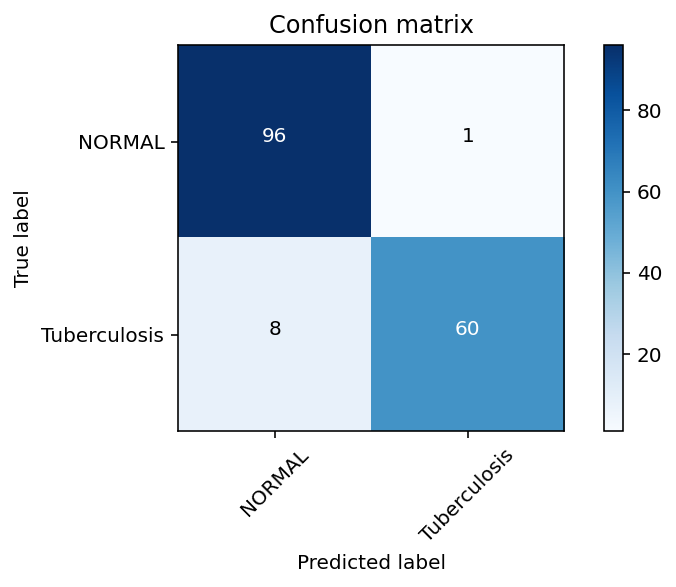

In [14]:
%time
CHECK_POINT_PATH = '/home/linh/Downloads/TB/weights/EfficientNet_B3.pth'

try:
    checkpoint = torch.load(CHECK_POINT_PATH)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")

def load_model(path):                                
    model.load_state_dict(checkpoint['model_state_dict'])
    best_model_wts = copy.deepcopy(model.state_dict())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    best_loss = checkpoint['best_val_loss']
    best_acc = checkpoint['best_val_accuracy']
load_model(CHECK_POINT_PATH) 
model.to(device)
model.eval()
since = time.time()

y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(data_loader['test']):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))
        
time_elapsed = time.time() - since

print('Inference time is {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['NORMAL', 'Tuberculosis']

plot_confusion_matrix(confusion_mtx, plot_labels)
report = classification_report(y_label, y_predict, digits=4)
print(report)

ROC curve (area = 0.9360)


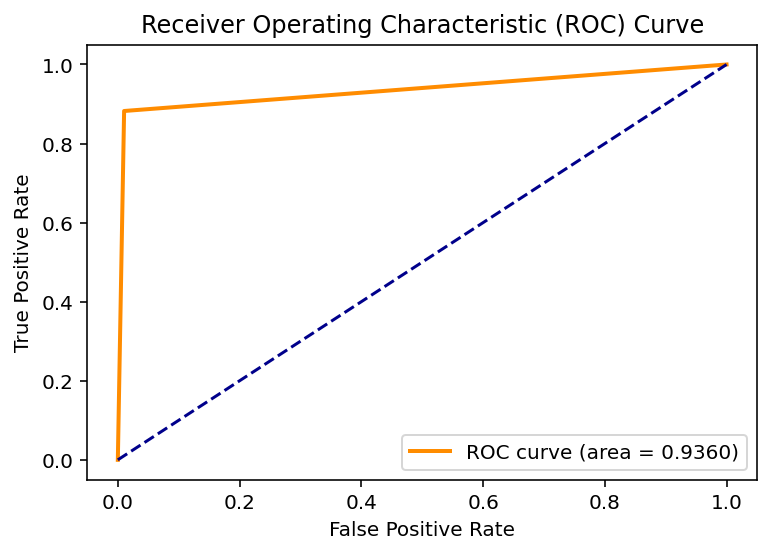

In [15]:
roc_auc = roc_auc_score(y_label, y_predict)
print('ROC curve (area = %0.4f)' % roc_auc)
fpr, tpr, thresholds = roc_curve(y_label, y_predict)
plot_roc_curve(fpr, tpr)

In [ ]:
def get_preds(model,device=None,tta=3):
    device=torch.device("cuda:1")
    model.to(device)
    preds = np.zeros(len(dataset_sizes['test']))
    for tta_id in range(tta):
        test_preds = []
        with torch.no_grad():
            for xb in data_loader['test']:
                xb = xb.to(device)
                out = model(xb)
                out = torch.sigmoid(out)
                test_preds.extend(out.cpu().numpy())
            preds += np.array(test_preds).reshape(-1)
        print(f'TTA {tta_id}')
    preds /= tta
    return preds
preds = get_preds(model,tta=25)  

In [ ]:
subm = pd.read_csv("/home/linh/Downloads/TB/SampleSubmission.csv")
subm.LABEL = preds
subm.to_csv('/home/linh/Downloads/TB/submission.csv',index=False)